In [0]:
!pip install gdal
!pip install rasterio
!pip install sentinelsat

In [0]:
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import gdal
from gdalconst import GA_ReadOnly 
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import numpy as np
from collections import Counter
from tqdm import tqdm_notebook as tqdm
IMG_SIZE=1031
import rasterio
from rasterio.plot import show
import subprocess
import os
import math
from sklearn.preprocessing import minmax_scale
from google.colab import drive
drive.mount('/content/drive')
COORDINATE_SYSTEM='EPSG:32632'
BIG_X_SIZE=12371
BIG_Y_SIZE=12371

# **GHS BUILT-UP**

**DOWNLOAD CLC REFERENCE DATA**

In [4]:
subprocess.run(['wget', 'https://land.copernicus.eu/land-files/7ac95361f9ac3cecdf37785bc183ff02dd765a16.zip'])
subprocess.run(['unzip' ,'7ac95361f9ac3cecdf37785bc183ff02dd765a16.zip'])
subprocess.run(['unzip' ,'clc2018_clc2018_v2018_20_raster100m.zip'])
subprocess.run(['gdalwarp','-co','COMPRESS=DEFLATE','-t_srs',COORDINATE_SYSTEM,'clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif','europe.tif'])


CompletedProcess(args=['gdalwarp', '-co', 'COMPRESS=DEFLATE', '-t_srs', 'EPSG:32632', 'clc2018_clc2018_v2018_20_raster100m/CLC2018_CLC2018_V2018_20.tif', 'europe.tif'], returncode=0)

**STEP 1 : DATA PREPROCESSING**

In [0]:
def download_scene(file_id):
  api = SentinelAPI('s5pguest', 's5pguest',api_url='https://scihub.copernicus.eu/apihub')
  api.download(file_id)

def unzip_scene(file_name):
  subprocess.call('unzip '+file_name,shell=True)

def jp2_to_tif(input_file,output_file):
  subprocess.call('gdal_translate ' +input_file+' '+output_file,shell=True)

def clip_ref_scene(input_file,output_file):
  data=gdal.Open(input_file,GA_ReadOnly) 
  geoTransform=data.GetGeoTransform() 
  minx=geoTransform[0] 
  maxy=geoTransform[3] 
  maxx = minx + geoTransform[1] * data.RasterXSize 
  miny = maxy + geoTransform[5] * data.RasterYSize 
  subprocess.call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff europe.tif ' +output_file, shell=True) 

def resize_scene(input_file,output_file):
  subprocess.call('gdal_translate -co QUALITY=100 -co PROGRESSIVE=ON -outsize '+str(IMG_SIZE)+' '+str(IMG_SIZE)+' -r bilinear '+input_file+' '+output_file,shell=True)

def create_new_tif(sourceraster, targetraster,array2d,nbands):
  with rasterio.open(sourceraster) as src:
    data = src.read()
    metadata = src.profile
  metadata['count']=nbands
  with rasterio.open(targetraster, 'w', **metadata) as dst:
    dst.write(array2d, 1)
    print('New tif created')

def resize_scene_custom_size(input_file,output_file,xsize,ysize):
  subprocess.call('gdal_translate -co QUALITY=100 -co PROGRESSIVE=ON -outsize '+str(xsize)+' '+str(ysize)+' '+input_file+' '+output_file,shell=True)

def change_pixel_size(inputfile,outputfile,pixelsize):
  subprocess.call('gdalwarp -tr '+ str(pixelsize)+' '+str(pixelsize)+' '+inputfile+' '+outputfile,shell=True)

def change_coordinate_system(inputfile,outputfile):
  subprocess.run(['gdalwarp','-co','COMPRESS=DEFLATE','-t_srs',COORDINATE_SYSTEM,inputfile,outputfile])

def clip_ref_scene_pop(input_file,output_file):
  data=gdal.Open(input_file,GA_ReadOnly) 
  geoTransform=data.GetGeoTransform() 
  minx=geoTransform[0] 
  maxy=geoTransform[3] 
  maxx = minx + geoTransform[1] * data.RasterXSize 
  miny = maxy + geoTransform[5] * data.RasterYSize 
  subprocess.call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff world-population.tif ' +output_file, shell=True) 

In [6]:
download_scene('cbb628b9-8399-4a24-aaeb-b5d5bdc49be0')
unzip_scene('/content/S2A_MSIL1C_20190926T105811_N0208_R094_T30TVK_20190926T130550.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190926T105811_N0208_R094_T30TVK_20190926T130550.SAFE/GRANULE/L1C_T30TVK_A022256_20190926T110642/IMG_DATA/T30TVK_20190926T105811_TCI.jp2','test-full-temp.tif')
change_coordinate_system('test-full-temp.tif','test-full.tif')
clip_ref_scene('test-full.tif','test-y-temp.tif')
resize_scene('test-y-temp.tif','test-y.tif')
resize_scene('test-full.tif','test.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190926T105811_N0208_R094_T30TVK_20190926T130550.SAFE/GRANULE/L1C_T30TVK_A022256_20190926T110642/IMG_DATA/T30TVK_20190926T105811_B08.jp2','test-b8-full-temp.tif')
change_coordinate_system('test-b8-full-temp.tif','test-b8-full.tif')
clip_ref_scene('test-b8-full.tif','test-b8-y-temp.tif')
resize_scene('test-b8-y-temp.tif','test-b8-y.tif')
resize_scene('test-b8-full.tif','test-b8.tif')


Downloading: 100%|██████████| 900M/900M [00:31<00:00, 28.1MB/s]
MD5 checksumming: 100%|██████████| 900M/900M [00:02<00:00, 439MB/s]


In [134]:
download_scene('742eb824-df10-4402-866e-0d92e8575aa4')
unzip_scene('/content/S2A_MSIL1C_20190723T101031_N0208_R022_T32TQQ_20190723T121220.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190723T101031_N0208_R022_T32TQQ_20190723T121220.SAFE/GRANULE/L1C_T32TQQ_A021326_20190723T101347/IMG_DATA/T32TQQ_20190723T101031_TCI.jp2','test-full-temp.tif')
change_coordinate_system('test-full-temp.tif','test-full.tif')
clip_ref_scene('test-full.tif','test-y-temp.tif')
resize_scene('test-y-temp.tif','test-y.tif')
resize_scene('test-full.tif','test.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190723T101031_N0208_R022_T32TQQ_20190723T121220.SAFE/GRANULE/L1C_T32TQQ_A021326_20190723T101347/IMG_DATA/T32TQQ_20190723T101031_B08.jp2','test-b8-full-temp.tif')
change_coordinate_system('test-b8-full-temp.tif','test-b8-full.tif')
clip_ref_scene('test-b8-full.tif','test-b8-y-temp.tif')
resize_scene('test-b8-y-temp.tif','test-b8-y.tif')
resize_scene('test-b8-full.tif','test-b8.tif')

Downloading: 100%|██████████| 757M/757M [00:26<00:00, 29.2MB/s]
MD5 checksumming: 100%|██████████| 757M/757M [00:01<00:00, 434MB/s]


**DOWNLOAD GPW DATA**

In [7]:
!unzip '/content/drive/My Drive/Colab_Notebooks/gpw-v4-population-count-rev11_2015_30_sec_tif.zip'
change_coordinate_system('/content/gpw_v4_population_count_rev11_2015_30_sec.tif','world-population.tif')
# clip_ref_scene_pop('test-full.tif','test-pop-full.tif')
# resize_scene('test-pop-full.tif','test-pop.tif')

Archive:  /content/drive/My Drive/Colab_Notebooks/gpw-v4-population-count-rev11_2015_30_sec_tif.zip
  inflating: gpw_v4_population_count_rev11_2015_30_sec.tif  
  inflating: gpw_v4_population_count_rev11_2015_30_sec_tif_readme.txt  


In [8]:
download_scene('4f07815d-5709-4b0b-8fdd-7e12c78e6546')
unzip_scene('S2A_MSIL1C_20190629T103031_N0207_R108_T32UMV_20190629T124358.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190629T103031_N0207_R108_T32UMV_20190629T124358.SAFE/GRANULE/L1C_T32UMV_A020983_20190629T103537/IMG_DATA/T32UMV_20190629T103031_TCI.jp2','s1-full0.tif')
change_coordinate_system('s1-full0.tif','s1-full.tif')
clip_ref_scene('s1-full.tif','s1-y-temp.tif')
resize_scene('s1-y-temp.tif','s1-y.tif')
resize_scene('s1-full.tif','s1.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190629T103031_N0207_R108_T32UMV_20190629T124358.SAFE/GRANULE/L1C_T32UMV_A020983_20190629T103537/IMG_DATA/T32UMV_20190629T103031_B08.jp2','s1-b8-full0.tif')
change_coordinate_system('s1-b8-full0.tif','s1-b8-full.tif')
clip_ref_scene('s1-b8-full.tif','s1-b8-y-temp.tif')
resize_scene('s1-b8-y-temp.tif','s1-b8-y.tif')
resize_scene('s1-b8-full.tif','s1-b8.tif')

Downloading: 100%|██████████| 854M/854M [00:30<00:00, 27.7MB/s]
MD5 checksumming: 100%|██████████| 854M/854M [00:01<00:00, 441MB/s]


In [9]:
download_scene('03cf3314-1b05-46f1-af1b-cee2652edf2b')
unzip_scene('S2B_MSIL1C_20190724T103029_N0208_R108_T32UMV_20190724T122822.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T32UMV_20190724T122822.SAFE/GRANULE/L1C_T32UMV_A012432_20190724T103030/IMG_DATA/T32UMV_20190724T103029_TCI.jp2','s2-full0.tif')
change_coordinate_system('s2-full0.tif','s2-full.tif')
clip_ref_scene('s2-full.tif','s2-y-temp.tif')
resize_scene('s2-y-temp.tif','s2-y.tif')
resize_scene('s2-full.tif','s2.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T32UMV_20190724T122822.SAFE/GRANULE/L1C_T32UMV_A012432_20190724T103030/IMG_DATA/T32UMV_20190724T103029_B08.jp2','s2-b8-full0.tif')
change_coordinate_system('s2-b8-full0.tif','s2-b8-full.tif')
clip_ref_scene('s2-b8-full.tif','s2-b8-y-temp.tif')
resize_scene('s2-b8-y-temp.tif','s2-b8-y.tif')
resize_scene('s2-b8-full.tif','s2-b8.tif')

Downloading: 100%|██████████| 840M/840M [00:36<00:00, 23.3MB/s]
MD5 checksumming: 100%|██████████| 840M/840M [00:01<00:00, 442MB/s]


In [10]:
download_scene('67a87302-2ff4-4c81-9e5e-792367578f6d')
unzip_scene('S2B_MSIL1C_20190921T105739_N0208_R094_T30UYC_20190921T131721.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190921T105739_N0208_R094_T30UYC_20190921T131721.SAFE/GRANULE/L1C_T30UYC_A013276_20190921T110218/IMG_DATA/T30UYC_20190921T105739_TCI.jp2','s3-full-temp.tif')
change_coordinate_system('s3-full-temp.tif','s3-full.tif')
clip_ref_scene('s3-full.tif','s3-y-temp.tif')
resize_scene('s3-y-temp.tif','s3-y.tif')
resize_scene('s3-full.tif','s3.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190921T105739_N0208_R094_T30UYC_20190921T131721.SAFE/GRANULE/L1C_T30UYC_A013276_20190921T110218/IMG_DATA/T30UYC_20190921T105739_B08.jp2','s3-b8-full-temp.tif')
change_coordinate_system('s3-b8-full-temp.tif','s3-b8-full.tif')
clip_ref_scene('s3-b8-full.tif','s3-b8-y-temp.tif')
resize_scene('s3-b8-y-temp.tif','s3-b8-y.tif')
resize_scene('s3-b8-full.tif','s3-b8.tif')

Downloading: 100%|██████████| 818M/818M [00:28<00:00, 28.4MB/s]
MD5 checksumming: 100%|██████████| 818M/818M [00:01<00:00, 437MB/s]


In [11]:
download_scene('c04d2ba0-4880-4dcf-a733-879231478aa3')
unzip_scene('S2B_MSIL1C_20190724T103029_N0208_R108_T31TGN_20190724T122822.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T31TGN_20190724T122822.SAFE/GRANULE/L1C_T31TGN_A012432_20190724T103030/IMG_DATA/T31TGN_20190724T103029_TCI.jp2','s4-full-temp.tif')
change_coordinate_system('s4-full-temp.tif','s4-full.tif')
clip_ref_scene('s4-full.tif','s4-y-temp.tif')
resize_scene('s4-y-temp.tif','s4-y.tif')
resize_scene('s4-full.tif','s4.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190724T103029_N0208_R108_T31TGN_20190724T122822.SAFE/GRANULE/L1C_T31TGN_A012432_20190724T103030/IMG_DATA/T31TGN_20190724T103029_B08.jp2','s4-b8-full-temp.tif')
change_coordinate_system('s4-b8-full-temp.tif','s4-b8-full.tif')
clip_ref_scene('s4-b8-full.tif','s4-b8-y-temp.tif')
resize_scene('s4-b8-y-temp.tif','s4-b8-y.tif')
resize_scene('s4-b8-full.tif','s4-b8.tif')

Downloading: 100%|██████████| 824M/824M [00:29<00:00, 28.3MB/s]
MD5 checksumming: 100%|██████████| 824M/824M [00:01<00:00, 442MB/s]


In [12]:
download_scene('4557d038-7f7e-4356-b410-5c6e7d741e7f')
unzip_scene('/content/S2A_MSIL1C_20190904T102021_N0208_R065_T32TNT_20190904T123501.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190904T102021_N0208_R065_T32TNT_20190904T123501.SAFE/GRANULE/L1C_T32TNT_A021941_20190904T102045/IMG_DATA/T32TNT_20190904T102021_TCI.jp2','s5-full0.tif')
change_coordinate_system('s5-full0.tif','s5-full.tif')
clip_ref_scene('s5-full.tif','s5-y-temp.tif')
resize_scene('s5-y-temp.tif','s5-y.tif')
resize_scene('s5-full.tif','s5.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190904T102021_N0208_R065_T32TNT_20190904T123501.SAFE/GRANULE/L1C_T32TNT_A021941_20190904T102045/IMG_DATA/T32TNT_20190904T102021_B08.jp2','s5-b8-full0.tif')
change_coordinate_system('s5-b8-full0.tif','s5-b8-full.tif')
clip_ref_scene('s5-b8-full.tif','s5-b8-y-temp.tif')
resize_scene('s5-b8-y-temp.tif','s5-b8-y.tif')
resize_scene('s5-b8-full.tif','s5-b8.tif')

Downloading: 100%|██████████| 847M/847M [00:30<00:00, 28.2MB/s]
MD5 checksumming: 100%|██████████| 847M/847M [00:01<00:00, 439MB/s]


In [13]:
download_scene('336a6ef0-784a-4a90-8333-02ed7ae93b85')
unzip_scene('/content/S2B_MSIL1C_20190913T100029_N0208_R122_T33TVJ_20190913T134222.zip')
jp2_to_tif('/content/S2B_MSIL1C_20190913T100029_N0208_R122_T33TVJ_20190913T134222.SAFE/GRANULE/L1C_T33TVJ_A013161_20190913T100548/IMG_DATA/T33TVJ_20190913T100029_TCI.jp2','s6-full-temp.tif')
change_coordinate_system('s6-full-temp.tif','s6-full.tif')
clip_ref_scene('s6-full.tif','s6-y-temp.tif')
resize_scene('s6-y-temp.tif','s6-y.tif')
resize_scene('s6-full.tif','s6.tif')
jp2_to_tif('/content/S2B_MSIL1C_20190913T100029_N0208_R122_T33TVJ_20190913T134222.SAFE/GRANULE/L1C_T33TVJ_A013161_20190913T100548/IMG_DATA/T33TVJ_20190913T100029_B08.jp2','s6-b8-full-temp.tif')
change_coordinate_system('s6-b8-full-temp.tif','s6-b8-full.tif')
clip_ref_scene('s6-b8-full.tif','s6-b8-y-temp.tif')
resize_scene('s6-b8-y-temp.tif','s6-b8-y.tif')
resize_scene('s6-b8-full.tif','s6-b8.tif')

Downloading: 100%|██████████| 555M/555M [00:19<00:00, 28.1MB/s]
MD5 checksumming: 100%|██████████| 555M/555M [00:01<00:00, 429MB/s]


In [14]:
download_scene('e27091e1-9c59-4326-8b3f-2dfd81d99c65')
unzip_scene('/content/S2A_MSIL1C_20190922T094031_N0208_R036_T34TCT_20190922T101504.zip')
jp2_to_tif('/content/S2A_MSIL1C_20190922T094031_N0208_R036_T34TCT_20190922T101504.SAFE/GRANULE/L1C_T34TCT_A022198_20190922T094031/IMG_DATA/T34TCT_20190922T094031_TCI.jp2','s7-full-temp.tif')
change_coordinate_system('s7-full-temp.tif','s7-full.tif')
clip_ref_scene('s7-full.tif','s7-y-temp.tif')
resize_scene('s7-y-temp.tif','s7-y.tif')
resize_scene('s7-full.tif','s7.tif')
jp2_to_tif('/content/S2A_MSIL1C_20190922T094031_N0208_R036_T34TCT_20190922T101504.SAFE/GRANULE/L1C_T34TCT_A022198_20190922T094031/IMG_DATA/T34TCT_20190922T094031_B08.jp2','s7-b8-full-temp.tif')
change_coordinate_system('s7-b8-full-temp.tif','s7-b8-full.tif')
clip_ref_scene('s7-b8-full.tif','s7-b8-y-temp.tif')
resize_scene('s7-b8-y-temp.tif','s7-b8-y.tif')
resize_scene('s7-b8-full.tif','s7-b8.tif')

Downloading: 100%|██████████| 839M/839M [00:30<00:00, 27.5MB/s]
MD5 checksumming: 100%|██████████| 839M/839M [00:01<00:00, 439MB/s]


**VISUALIZE TEST SET - PORTO VIRO REGION - ITALY**

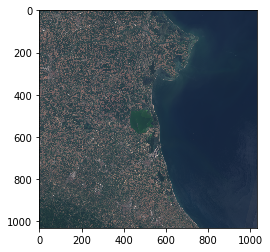

In [214]:
dataset = rasterio.open('test.tif')
show(dataset.read([1,2,3]))

In [0]:
tif1=gdal.Open('s1.tif')
s1r = tif1.GetRasterBand(1).ReadAsArray()
s1g = tif1.GetRasterBand(2).ReadAsArray()
s1b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s1-b8.tif')
s1b8=tif1.GetRasterBand(1).ReadAsArray()

tif1=gdal.Open('s2.tif')
s2r = tif1.GetRasterBand(1).ReadAsArray()
s2g = tif1.GetRasterBand(2).ReadAsArray()
s2b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s2-b8.tif')
s2b8=tif1.GetRasterBand(1).ReadAsArray()

tif1=gdal.Open('s3.tif')
s3r = tif1.GetRasterBand(1).ReadAsArray()
s3g = tif1.GetRasterBand(2).ReadAsArray()
s3b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s3-b8.tif')
s3b8=tif1.GetRasterBand(1).ReadAsArray()

tif1=gdal.Open('s4.tif')
s4r = tif1.GetRasterBand(1).ReadAsArray()
s4g = tif1.GetRasterBand(2).ReadAsArray()
s4b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s4-b8.tif')
s4b8=tif1.GetRasterBand(1).ReadAsArray()

tif1=gdal.Open('s5.tif')
s5r = tif1.GetRasterBand(1).ReadAsArray()
s5g = tif1.GetRasterBand(2).ReadAsArray()
s5b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s5-b8.tif')
s5b8=tif1.GetRasterBand(1).ReadAsArray()

tif1=gdal.Open('s6.tif')
s6r = tif1.GetRasterBand(1).ReadAsArray()
s6g = tif1.GetRasterBand(2).ReadAsArray()
s6b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s6-b8.tif')
s6b8=tif1.GetRasterBand(1).ReadAsArray()

tif1=gdal.Open('s7.tif')
s7r = tif1.GetRasterBand(1).ReadAsArray()
s7g = tif1.GetRasterBand(2).ReadAsArray()
s7b = tif1.GetRasterBand(3).ReadAsArray()
tif1=gdal.Open('s7-b8.tif')
s7b8=tif1.GetRasterBand(1).ReadAsArray()

In [0]:
tif2=gdal.Open('test-y.tif')
Y_raster_test= tif2.GetRasterBand(1).ReadAsArray()
Y_raster_test[Y_raster_test < 100] = 999
Y_raster_test[(Y_raster_test > 100)&(Y_raster_test <= 150)] = 0
Y_raster_test[(Y_raster_test > 150) & (Y_raster_test < 450)] = 125
Y_raster_test[(Y_raster_test >= 450) & (Y_raster_test < 530)] = 255
Y_raster_test[Y_raster_test > 530] = 255

In [0]:
Y_list=[]
for i in range(1,8):
    tif2=gdal.Open('s'+str(i)+'-y.tif')
    Y_raster_s1 = tif2.GetRasterBand(1).ReadAsArray()
    Y_raster_s1[Y_raster_s1 < 100] = 999
    Y_raster_s1[(Y_raster_s1 > 100)&(Y_raster_s1 <= 150)] = 0
    Y_raster_s1[(Y_raster_s1 > 150) & (Y_raster_s1 < 450)] = 125
    Y_raster_s1[(Y_raster_s1 >= 450) & (Y_raster_s1 < 530)] = 255
    Y_raster_s1[Y_raster_s1 > 530] = 255
    Y_list=Y_list+(Y_raster_s1.flatten().tolist())

In [141]:
print(np.unique(Y_list))

[  0 125 255]


In [0]:
#CONVERT RGB BANDS AS INPUT FEATURE SEQUENCES
#QUANTIZATION

rband_list=s1r.flatten().tolist()
rband_list=rband_list+(s2r.flatten().tolist())
rband_list=rband_list+(s3r.flatten().tolist())
rband_list=rband_list+(s4r.flatten().tolist())
rband_list=rband_list+(s5r.flatten().tolist())
rband_list=rband_list+(s6r.flatten().tolist())
rband_list=rband_list+(s7r.flatten().tolist())

gband_list=s1g.flatten().tolist()
gband_list=gband_list+(s2g.flatten().tolist())
gband_list=gband_list+(s3g.flatten().tolist())
gband_list=gband_list+(s4g.flatten().tolist())
gband_list=gband_list+(s5g.flatten().tolist())
gband_list=gband_list+(s6g.flatten().tolist())
gband_list=gband_list+(s7g.flatten().tolist())

bband_list=s1b.flatten().tolist()
bband_list=bband_list+(s2b.flatten().tolist())
bband_list=bband_list+(s3b.flatten().tolist())
bband_list=bband_list+(s4b.flatten().tolist())
bband_list=bband_list+(s5b.flatten().tolist())
bband_list=bband_list+(s6b.flatten().tolist())
bband_list=bband_list+(s7b.flatten().tolist())

band8_list=s1b8.flatten().tolist()
band8_list=band8_list+(s2b8.flatten().tolist())
band8_list=band8_list+(s3b8.flatten().tolist())
band8_list=band8_list+(s4b8.flatten().tolist())
band8_list=band8_list+(s5b8.flatten().tolist())
band8_list=band8_list+(s6b8.flatten().tolist())
band8_list=band8_list+(s7b8.flatten().tolist())

q1=max(rband_list)/16
q2=max(gband_list)/16
q3=max(bband_list)/16
q4=max(band8_list)/16

rband_list = [round(math.floor(x+0.5)/q1) for x in rband_list]
gband_list = [round(math.floor(x+0.5)/q2) for x in gband_list]
bband_list = [round(math.floor(x+0.5)/q3) for x in bband_list]
band8_list = [round(math.floor(x+0.5)/q4) for x in band8_list]

In [143]:
print(len(rband_list))

7440727


***SEQUENCE LIST AND ANTECEDENT-CONSEQUENT LIST(X->Y)***

In [0]:
sequences_list=[]
ante_consq_list=[]

In [145]:
for i in tqdm(range(len(rband_list))):
  sequences_list.append((rband_list[i],gband_list[i],bband_list[i],band8_list[i]))
  ante_consq_list.append((rband_list[i],gband_list[i],bband_list[i],band8_list[i],Y_list[i]))

print('BUILDING DATA DONE')



BUILDING DATA DONE


***RANDOM EXAMPLE - DATA STRUCTURE (R, G, B, B8, CLASS_LABEL)***

In [146]:
print ((ante_consq_list[600]))

(2, 3, 4, 3, 125)


***FIND UNIQUE SEQUENCES(X-cap) AND COUNT***

In [147]:
print('UNIQUE SEQUENCES COUNT: ')
print(len(list(set(sequences_list))))
unique_X_sequences=list(set(sequences_list))

UNIQUE SEQUENCES COUNT: 
862




---



***STEP 2:***

*   ***ASSOCIATION ANALYSIS***
*   ***EVIDENCE BASED NORMALIZED DIFFERENTIAL INDEX(ENDI) MEASURE***




***HELPER FUNCTIONS:***

In [0]:
#ONE VARIATION OF ENDI INTERESTINGNESS MEASURE
def calculate_ENDI(positive,negative):
  if (positive==0) and (negative==0) : return 0
  return (positive-negative)/(positive+negative)

In [0]:
#POSITIVE EVIDENCES
def positive_count(sequence,class_name):
  item = list(sequence)
  item.append(class_name)
  c=counter[tuple(item)]
  return c

#NEGATIVE EVIDENCES
def negative_count(sequence, class_list):
  negative_classcount=0
  for c in  class_list:
    item = list(sequence)
    item.append(c)
    negative_classcount=negative_classcount+counter[tuple(item)]

  return negative_classcount

In [0]:
#COUNT FREQUENCIES OF EACH UNIQUE SEQUENCE
counter=Counter(ante_consq_list)

***CALCULATE ENDI MEASURE FOR ALL THE CLASSES PER SEQUENCE DATA***

In [151]:
#GENERATE A DICTIONARY OF THE FORM : {(unique sequence) : [ENDI MEASURE-CLASS 0, ENDI MEASURE-CLASS 1]}
ENDI_table_dictionary={}

for i in tqdm(range(len(unique_X_sequences))):
  seq=unique_X_sequences[i]
  ENDI_class_0=calculate_ENDI(positive_count(seq,0),negative_count(seq,[125,255]))
  ENDI_class_1=calculate_ENDI(positive_count(seq,125),negative_count(seq,[0,255]))
  ENDI_class_2=calculate_ENDI(positive_count(seq,255),negative_count(seq,[0,125]))
  ENDI_table_dictionary[seq]=[ENDI_class_0,ENDI_class_1,ENDI_class_2]

print('BUILDING DICTIONARY DONE')

#PRINT RANDOM DATA POINT
#print(ENDI_table_dictionary[unique_X_sequences[5000]])



BUILDING DICTIONARY DONE




---



***STEP 3 : CLASSIFICATION AND VISUALIZATION***

In [0]:
def classification(file_name,band8filename):
          new_image=gdal.Open(file_name)
          rband_new = new_image.GetRasterBand(1).ReadAsArray()
          gband_new = new_image.GetRasterBand(2).ReadAsArray()
          bband_new = new_image.GetRasterBand(3).ReadAsArray()
          tif1=gdal.Open(band8filename)
          band8_new=tif1.GetRasterBand(1).ReadAsArray()

          rband_list_new=rband_new.flatten().tolist()
          gband_list_new=gband_new.flatten().tolist()
          bband_list_new=bband_new.flatten().tolist()
          band8_list_new=band8_new.flatten().tolist()

          q1=max(rband_list_new)/16
          q2=max(gband_list_new)/16
          q3=max(bband_list_new)/16
          q4=max(band8_list_new)/16

          rband_list_new = [round(math.floor(x+0.5)/q1) for x in rband_list_new]
          gband_list_new = [round(math.floor(x+0.5)/q2) for x in gband_list_new]
          bband_list_new = [round(math.floor(x+0.5)/q3) for x in bband_list_new]
          band8_list_new = [round(math.floor(x+0.5)/q4) for x in band8_list_new]


          final_pred_list=[]
          final_confidence_list=[]

          for i in tqdm(range(len(rband_list_new))):

            if ((rband_list_new[i],gband_list_new[i],bband_list_new[i],band8_list_new[i])) in ENDI_table_dictionary:
                  ENDI_vals=ENDI_table_dictionary[(rband_list_new[i],gband_list_new[i],bband_list_new[i],band8_list_new[i])]
                  max_val = max(ENDI_vals)
                  if max_val >= 0.5:
                        index_max = ENDI_vals.index(max_val)
                        final_pred_list.append(index_max)
                        final_confidence_list.append(ENDI_vals[0]) 
                  else :
                        final_pred_list.append(1)
                        final_confidence_list.append(ENDI_vals[0])

            else:
              final_pred_list.append(1)
              final_confidence_list.append(-1)

          final_confidence_list_scaled = minmax_scale(final_confidence_list, feature_range=(0,100))
          return final_pred_list,final_confidence_list_scaled

In [0]:
def visualization(any_list,xsize,ysize,title,outputfile,colormap):
  numpy_array=np.asarray(any_list,dtype='uint8')
  #numpy_array[numpy_array == 1] = 125
  #numpy_array[numpy_array == 2] = 255
  final_image_array=numpy_array.reshape((xsize,ysize))
  fig, ax = plt.subplots()
  ax.set_title(title)
  img = ax.imshow(final_image_array,cmap=plt.get_cmap(colormap))
  fig.colorbar(img, ax=ax)
  fig.savefig(outputfile+'.png')

In [0]:
def metrics(y_actual, y_pred_original):
    numpy_array=np.asarray(y_pred_original)
    numpy_array[numpy_array == 1] = 125
    numpy_array[numpy_array == 2] = 255
    y_pred=numpy_array.tolist()
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in tqdm(range(len(y_pred))):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN



---



**VISUALIZATION OF RESULTS AND METRICS - PORTO VIRO AREA(ITALY)**

1) MADRID CLASSIFICATION RESULTS

In [155]:
prediction_list,confidence_list=classification('test-full.tif','test-b8-full.tif')


In [157]:
with rasterio.open('test-full.tif') as src:
    prof = src.profile
    print(prof)
    BIG_X_SIZE=prof['width']
    BIG_Y_SIZE=prof['height']

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 5000040.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}


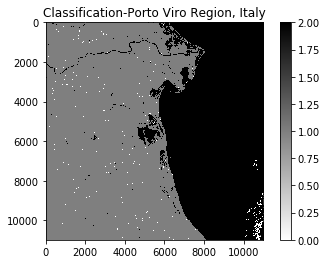

In [213]:
visualization(prediction_list,BIG_X_SIZE,BIG_Y_SIZE, 'Classification-Porto Viro Region, Italy','predictions-madrid',colormap='binary')

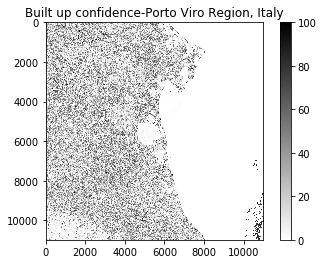

In [205]:
visualization(confidence_list,BIG_X_SIZE,BIG_Y_SIZE,'Built up confidence-Porto Viro Region, Italy','confidence-madrid',colormap='gist_yarg')

In [0]:
create_new_tif('test-full.tif','prediction-raster.tif',np.asarray(prediction_list,dtype='uint8').reshape(BIG_X_SIZE,BIG_Y_SIZE),1)

In [0]:
create_new_tif('test-full.tif','confidence-raster.tif',np.asarray(confidence_list,dtype='uint8').reshape(BIG_X_SIZE,BIG_Y_SIZE),1)

In [0]:
change_pixel_size('confidence-raster.tif','ghsl-built-confidence-raster-30m.tif',30)

In [0]:
change_pixel_size('prediction-raster.tif','ghsl-built-prediction-raster-30m.tif',30)

In [165]:
with rasterio.open('ghsl-built-prediction-raster-30m.tif') as src:
    metadata = src.profile
new_x_size=metadata['width']
new_y_size=metadata['height']

metadata

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(30.0, 0.0, 699960.0,
       0.0, -30.0, 5000040.0), 'tiled': False, 'interleave': 'band'}

In [0]:
clip_ref_scene_pop('test-full.tif','test-pop-full.tif')
resize_scene_custom_size('test-pop-full.tif','test-pop.tif',new_x_size,new_y_size)

In [0]:
# m=metrics(Y_raster_test.flatten().tolist(),prediction_list)
# unique, counts = np.unique(Y_raster_test.flatten().tolist(), return_counts=True)
# for i in range(0,3):
#   TP=m[1][i]
#   FP=m[2][i]
#   TN=m[3][i]
#   FN=m[4][i]
#   P=counts[i]
#   N=len(Y_list)-P
#   TPR=TP/P
#   TNR=TN/N
#   bal_measure = (TPR+TNR)/2
#   inf_accuracy=TPR-TNR
#   print('BALANCED ACCURACY FOR CLASS '+str(i)+" is "+ str(bal_measure))
#   print('INFORMEDNESS FOR CLASS '+str(i)+" is "+str(inf_accuracy))


2)ORIGINAL RGB IMAGE

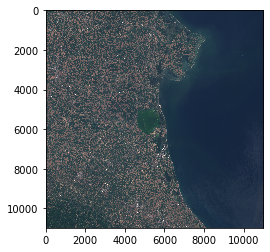

In [167]:
dataset = rasterio.open('test-full.tif')
show(dataset.read([1,2,3]))



---



# **GHS-POP**

**USING DASYMMETRIC MAPPING ALGORITHM**

In [0]:
pop1=gdal.Open('test-pop.tif')
pop2d = pop1.GetRasterBand(1).ReadAsArray()
pop2d[pop2d < 0] = 0
pop1d=pop2d.flatten()

In [0]:
a=gdal.Open('ghsl-built-confidence-raster-30m.tif')
confidence_values_category=a.GetRasterBand(1).ReadAsArray().flatten()

In [0]:
confidence_values_category[confidence_values_category<30]=0
confidence_values_category[(confidence_values_category<60)&(confidence_values_category>=30)]=1
confidence_values_category[confidence_values_category>=60]=2

In [0]:
uniquevals, eachcount = np.unique(confidence_values_category, return_counts=True)

In [172]:
print(uniquevals)
uhigh_population=0
ulow_population=0
non_population=0

[0 1 2]


In [0]:
for i in range(0,pop1d.size):
  if(confidence_values_category[i]==0):
    non_population=non_population+pop1d[i]
  elif(confidence_values_category[i]==1):
    ulow_population=ulow_population+pop1d[i]
  else:
     uhigh_population=uhigh_population+pop1d[i]

In [0]:
uhigh_area=eachcount[2]*30*30
ulow_area=eachcount[1]*30*30
non_population_area=eachcount[0]*30*30

In [0]:
print(non_population+ulow_population+uhigh_population)

In [0]:
uhigh_density=uhigh_population/uhigh_area
ulow_density=ulow_population/ulow_area
non_population_density=non_population/non_population_area

In [177]:
print(uhigh_density)
print(ulow_density)
print(non_population_density)

0.17968130165717552
0.13643456706856855
0.058427895500390334


In [0]:
d_uhigh=(uhigh_density)/(uhigh_density+ulow_density+non_population_density)
d_ulow=(ulow_density)/(uhigh_density+ulow_density+non_population_density)
d_non_population=(non_population_density)/(uhigh_density+ulow_density+non_population_density)

In [0]:
a_uhigh=(eachcount[2]/pop1d.size)/0.33
a_ulow=(eachcount[1]/pop1d.size)/0.33
a_non_population=(eachcount[0]/pop1d.size)/0.33

In [0]:
f_uhigh=(d_uhigh*a_uhigh)/((d_uhigh*a_uhigh)+(d_ulow*a_ulow)+(d_non_population*a_non_population))
f_ulow=(d_ulow*a_ulow)/((d_uhigh*a_uhigh)+(d_ulow*a_ulow)+(d_non_population*a_non_population))
f_non_population=(d_non_population*a_non_population)/((d_uhigh*a_uhigh)+(d_ulow*a_ulow)+(d_non_population*a_non_population))

In [0]:
total_pop=np.sum(pop1d)
pop_uhigh=(f_uhigh*total_pop)/eachcount[2]
pop_ulow=(f_ulow*total_pop)/eachcount[1]
pop_non_population=(f_non_population*total_pop)/eachcount[0]

In [0]:
final_ghspop1d=[]

for i in range(0,pop1d.size):
  if(confidence_values_category[i]==0):
    final_ghspop1d.append(pop_non_population)
  elif(confidence_values_category[i]==1):
    final_ghspop1d.append(pop_ulow)
  else:
     final_ghspop1d.append(pop_uhigh)

final_ghs_pop2d=np.reshape(final_ghspop1d,(new_x_size,new_y_size))

In [183]:
np.unique(final_ghs_pop2d)

array([ 52.58509941, 122.7910951 , 161.71315139])

In [0]:
create_new_tif('test-pop.tif','ghsl-pop-raster-30m.tif',np.asarray(final_ghspop1d,dtype='float32').reshape(new_x_size,new_y_size),1)

Text(0.5, 1.0, 'GHS POP')

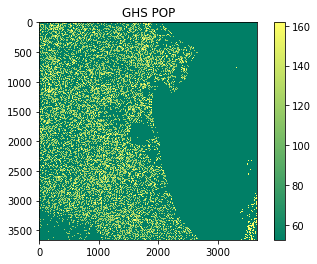

In [207]:
fig, ax = plt.subplots()
img = ax.imshow((final_ghs_pop2d),cmap=plt.get_cmap('summer'))
fig.colorbar(img, ax=ax)
ax.set_title('GHS POP')



---



# **GHS S-MOD**

In [0]:
def classify_urban_area(i,j,d,arr):
  n = arr[i-d:i+d+1, j-d:j+d+1].flatten()
  return n

In [0]:
cc=gdal.Open('ghsl-built-confidence-raster-30m.tif')
confidence2d = cc.GetRasterBand(1).ReadAsArray()
dd=gdal.Open('ghsl-pop-raster-30m.tif')
final_ghs_pop2d=dd.GetRasterBand(1).ReadAsArray()

CLASSIFY URBAN CENTRE, URBAN CLUSTER, RURAL AREA AND OTHER REGIONS

In [188]:
urban_array=np.zeros(final_ghs_pop2d.shape,dtype='uint8')
for ix,iy in tqdm(np.ndindex(final_ghs_pop2d.shape)):
    popcellvalue=final_ghs_pop2d[ix,iy]
    confidencecellvalue=confidence2d[ix,iy]

    if((popcellvalue>1500 or confidencecellvalue>50) and (np.sum(classify_urban_area(ix,iy,5,final_ghs_pop2d))>50000)):
      urban_array[ix,iy]=3
    elif (popcellvalue>300 and (np.sum(classify_urban_area(ix,iy,6,final_ghs_pop2d))>5000)):
      urban_array[ix,iy]=2
    elif(popcellvalue>1 and (np.sum(classify_urban_area(ix,iy,3,final_ghs_pop2d))<5000)):
      urban_array[ix,iy]=1

In [189]:
print(np.unique(urban_array, return_counts=True))

(array([0, 1], dtype=uint8), array([  983087, 12412513]))


In [0]:
# from matplotlib import colors
# import matplotlib.patches as mpatches
# fig, ax = plt.subplots()
# black_patch = mpatches.Patch(color='black', label='Urban Centre')
# dark_grey_patch=mpatches.Patch(color='grey', label='Urban Cluster')
# grey_patch = mpatches.Patch(color='lightgray', label='Others')
# white_patch = mpatches.Patch(color='white', label='Rural')

# ax.legend(handles=[black_patch,dark_grey_patch,white_patch, grey_patch], loc='lower right')
# img = ax.imshow(urban_array)
# ax.set_title('GHS-SMOD')

In [0]:
create_new_tif('test-pop.tif','ghsl-smod-raster-30m.tif',np.asarray(urban_array,dtype='float32'),1)

30m Saved BUILT, POP, SMOD Raster Information

In [193]:
!gdalinfo ghsl-smod-raster-30m.tif

Driver: GTiff/GeoTIFF
Files: ghsl-smod-raster-30m.tif
Size is 3660, 3660
Coordinate System is:
PROJCS["WGS 84 / UTM zone 32N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32632"]]
Origin = (699049.534879520535469,5000628.359786620363593)
Pixel Size = (29.973999881374677,-29.974155089881851)
Metadata:
  AREA_OR_POINT=A

In [211]:
!gdalinfo ghsl-built-prediction-raster-30m.tif

Driver: GTiff/GeoTIFF
Files: ghsl-built-prediction-raster-30m.tif
Size is 3660, 3660
Coordinate System is:
PROJCS["WGS 84 / UTM zone 32N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32632"]]
Origin = (699960.000000000000000,5000040.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Metadata:
  ARE

In [192]:
!gdalinfo ghsl-pop-raster-30m.tif

Driver: GTiff/GeoTIFF
Files: ghsl-pop-raster-30m.tif
Size is 3660, 3660
Coordinate System is:
PROJCS["WGS 84 / UTM zone 32N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32632"]]
Origin = (699049.534879520535469,5000628.359786620363593)
Pixel Size = (29.973999881374677,-29.974155089881851)
Metadata:
  AREA_OR_POINT=Ar



---

